# Artificial Intelligence Project 2 - Banking Customer Churn Prediction Dataset
The topic of this project is Supervised Learning.

The selected problem was the Banking Customer Churn Prediction.

This notebook aims to analyse the data related to the bank customers and their churn status, which indicates whether they have exited the bank or not.

## 1. Data Collection and Understanding

Here are the types of data present in the dataset:
* RowNumber - sequential number assigned to each row in the dataset (1 to 10000)
* CustomerId - unique identifier for each customer
* Surname - surname of the customer
* CreditScore - credit score of the customer
* Geography - geographical location of the customer (country or region)
* Gender - gender of the customer
* Age - age of the customer
* Tenure - number of years the customer has been with the bank
* Balance - account balance of the customer
* NumOfProducts - number of bank products the customer has
* HasCrCard - indicates whether the customer has a credit card (binary: yes(1)/no(0))
* IsActiveMember - indicates whether the customer is an active member (binary: yes(1)/no(0))
* EstimatedSalary - estimated salary of the customer
* Exited - indicates whether the customer has exited the bank (binary: yes(1)/no(0))


The project goal is to learn how to classify examples in terms of the concept under analysis given a dataset. We want to determine which bank customers features are capable of predicting customer churn using Classification Algorithms.

### Used Libraries

In [1]:
import warnings # Needed to ignore warnings
import time
import pandas as pd
import seaborn as sb
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

### Importing the dataset

In [2]:
df = pd.read_csv('data/Churn_Modelling.csv')
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


We also check the type of each column in the dataset.

In [3]:
for column_name, dtype in df.dtypes.items():
    print(f"{column_name}: {dtype}")

RowNumber: int64
CustomerId: int64
Surname: object
CreditScore: int64
Geography: object
Gender: object
Age: int64
Tenure: int64
Balance: float64
NumOfProducts: int64
HasCrCard: int64
IsActiveMember: int64
EstimatedSalary: float64
Exited: int64


## 2. Data Cleaning and Pre-Processing

Before starting to use a new dataset we have to clean it: check missing and null values, check for duplicates, etc.

To start, we check if there is any missing values and duplicated values in the dataset.

In [4]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.duplicated().sum()

0

From that we can see that there is no missing values or duplicated values in the dataset.

Datasets may contain other erroneous data that not a null value. These errors often manifest themselves as outliers: values that stray far away from the majority of the entries in our sample.

To check for outliers, boxplots may be useful.

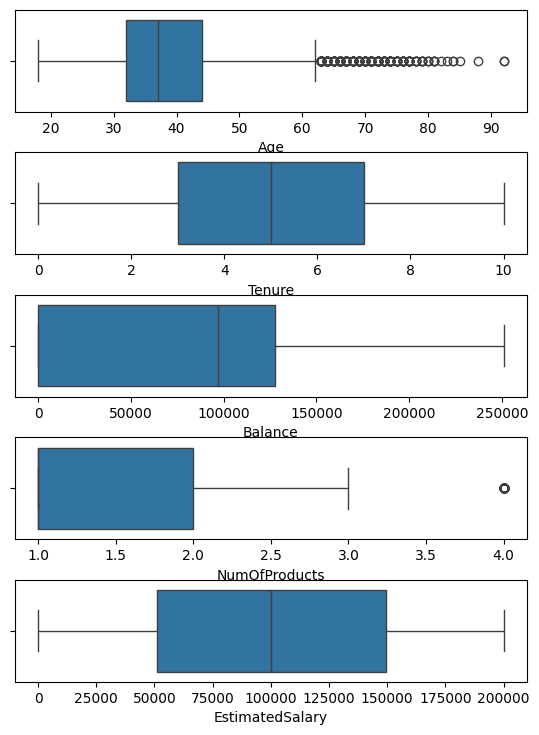

In [6]:
fig, ax = plt.subplots(5)

sb.boxplot(x=df["Age"], orient="h", ax=ax[0])
sb.boxplot(x=df["Tenure"], orient="h", ax=ax[1])
sb.boxplot(x=df["Balance"], orient="h", ax=ax[2])
sb.boxplot(x=df["NumOfProducts"], orient="h", ax=ax[3])
sb.boxplot(x=df["EstimatedSalary"], orient="h", ax=ax[4])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

To complement the boxplots above we check if there is negative values in columns that are not suppose to have negative values like the column "Age", "Tenure", "Balance", "NumOfProducts" or "EstimatedSalary".

In [7]:
# Negative Age, Tenure, Balance, NumOfProducts or EstimatedSalary are errors
df[(df.Age < 0) | (df.Tenure < 0) | (df.Balance < 0) | (df.NumOfProducts < 0) | (df.EstimatedSalary < 0)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


From that we can conclude that are no impossible values in the columns with continuous attributes.

In the attributes that are suppose to be binary (yes(1)/no(0)), all we can do is check whether they are indeed binary or there is any wrong entry.

In [8]:
print(df["HasCrCard"].value_counts())
print(df["IsActiveMember"].value_counts())
print(df["Exited"].value_counts())

HasCrCard
1    7055
0    2945
Name: count, dtype: int64
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64
Exited
0    7963
1    2037
Name: count, dtype: int64


The data set is clean and valid. The only operation we will be dropping the collumns that are not relevant for the problem we have in hands.

We drop the columns "RowNumber", "CustomerId" and "Surname" because they are not relevant for the task we need to performe on the dataset.

In [9]:
# Dropping columns RowNumber, CustomerId and Surname don't have any significance
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 'columns')

After the modifications we check if the dataset is correct.

In [10]:
for column_name, dtype in df.dtypes.items():
    print(f"{column_name}: {dtype}")

CreditScore: int64
Geography: object
Gender: object
Age: int64
Tenure: int64
Balance: float64
NumOfProducts: int64
HasCrCard: int64
IsActiveMember: int64
EstimatedSalary: float64
Exited: int64


## 3. Data Analysis

The third step is to analyse the data in order to infer relationships between the attributes and understand the data better.

Our data set is composed of various continuous and discrete attributes that can be indicative of churn, as well as the attribute we seek to train our model to predict ("Exited").

First, we check the distribution of the variable we want our model to predict.

Text(0.5, 1.0, 'Exited distribution\n 0 - No Exit   1 - Exit')

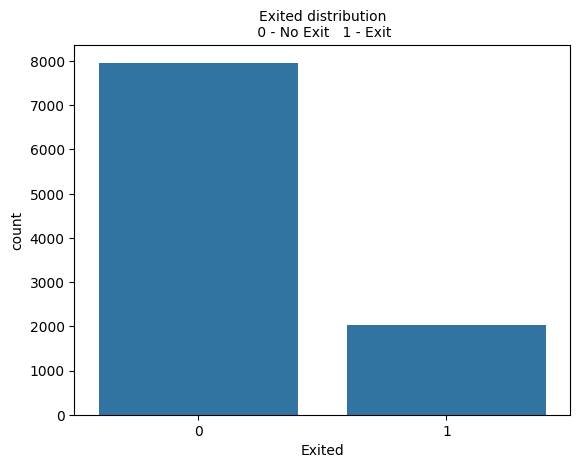

In [11]:
sb.countplot(x=df.Exited)
plt.title('Exited distribution\n 0 - No Exit   1 - Exit', fontsize=10)

We conclude that there are many more people that stay in the bank than people who exit the bank.

We will now compare how the different features are distributed, based on the "Exited" column.

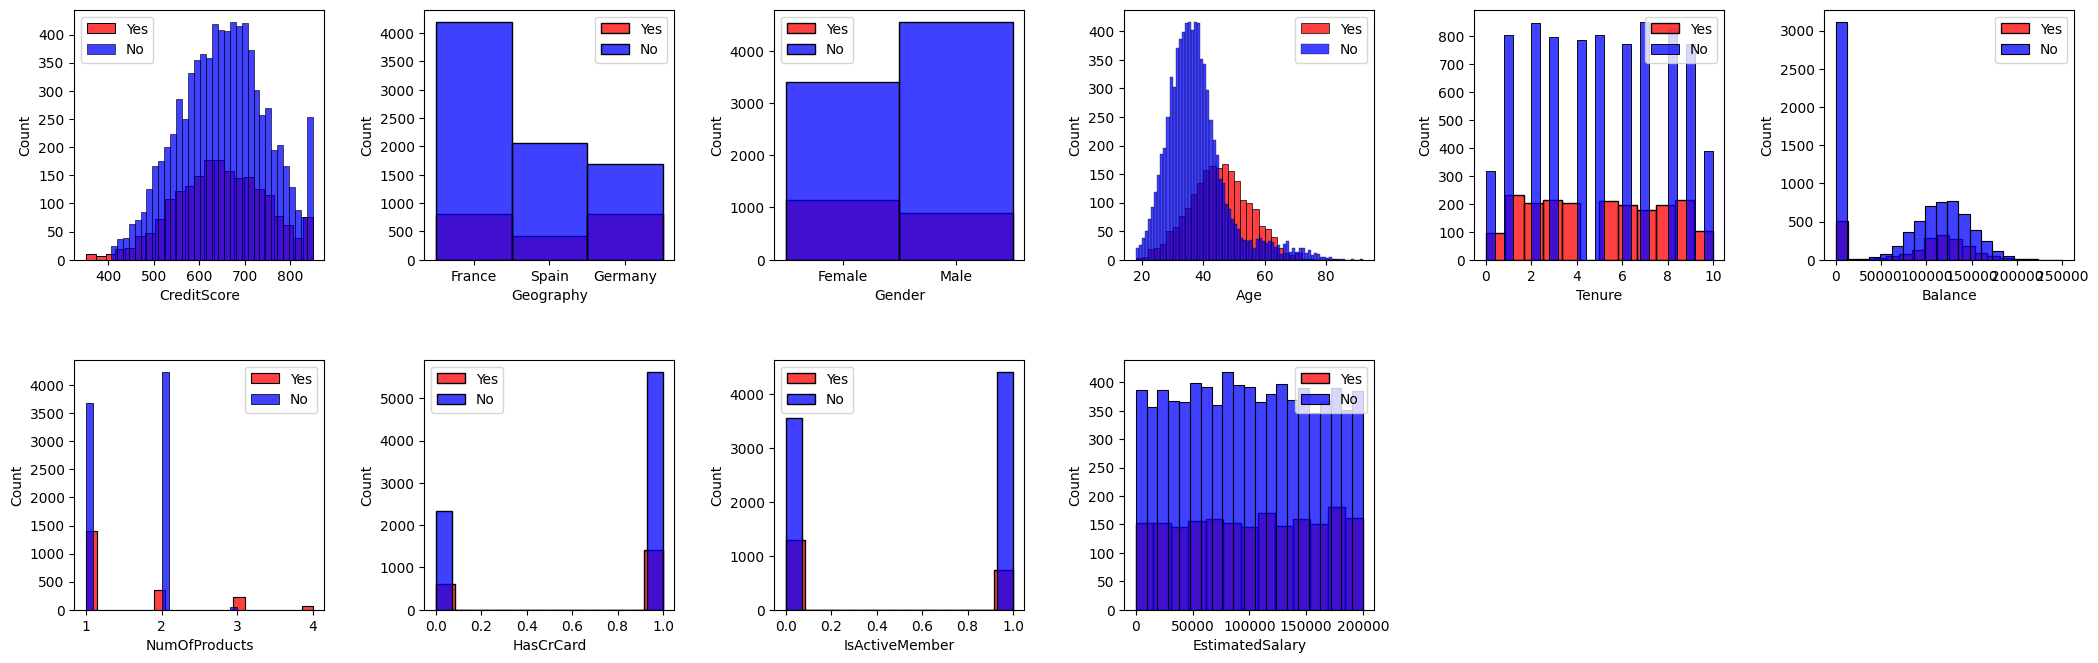

In [12]:
plt.figure(figsize=(25,25))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

df1 = df[df['Exited']==1].drop(['Exited'],axis=1)
df2 = df[df['Exited']==0].drop(['Exited'],axis=1)

cols = list(df1.columns)

for i, col in enumerate(cols):
    plt.subplot(6,6,i+1)
    sb.histplot(data=df1[col], color='red', label = 'Yes', kde=False)
    sb.histplot(data=df2[col], color='blue', label = 'No', kde=False)
    _,axes = plt.gca().get_legend_handles_labels()
    plt.legend(axes,prop={'size': 10})

plt.show()

From the plots, we can conclude that from the people that leave the bank the majority of them are from France and Germany, the middle aged to old people are more susceptible to leave the bank and that female people (although not by a big difference) are more susceptible to leave the bank.

The only operation we will be applying to apply the algorithm and see the correlation matrix between the features is changing the values of the variables that have the type object to int. <br>
First, we change the values of the columns "Gender" and "Geography" to int values.

In [13]:
# Check all the different values in this columns
print(df["Gender"].value_counts())
print(df["Geography"].value_counts())

Gender
Male      5457
Female    4543
Name: count, dtype: int64
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64


In [14]:
# Create a dictionary mapping gender values to integer values
gender_mapping = {'Male': 1, 'Female': 0}

# Use the map function to replace gender values with integers
df['Gender'] = df['Gender'].map(gender_mapping)

# Create a dictionary mapping geography values to integer values
geography_mapping = {'France': 2, 'Spain': 1, 'Germany': 0}

# Use the map function to replace geography values with integers
df['Geography'] = df['Geography'].map(geography_mapping)

After the modification, we check if the dataset is correct.

In [15]:
for column_name, dtype in df.dtypes.items():
    print(f"{column_name}: {dtype}")

CreditScore: int64
Geography: int64
Gender: int64
Age: int64
Tenure: int64
Balance: float64
NumOfProducts: int64
HasCrCard: int64
IsActiveMember: int64
EstimatedSalary: float64
Exited: int64


<Axes: >

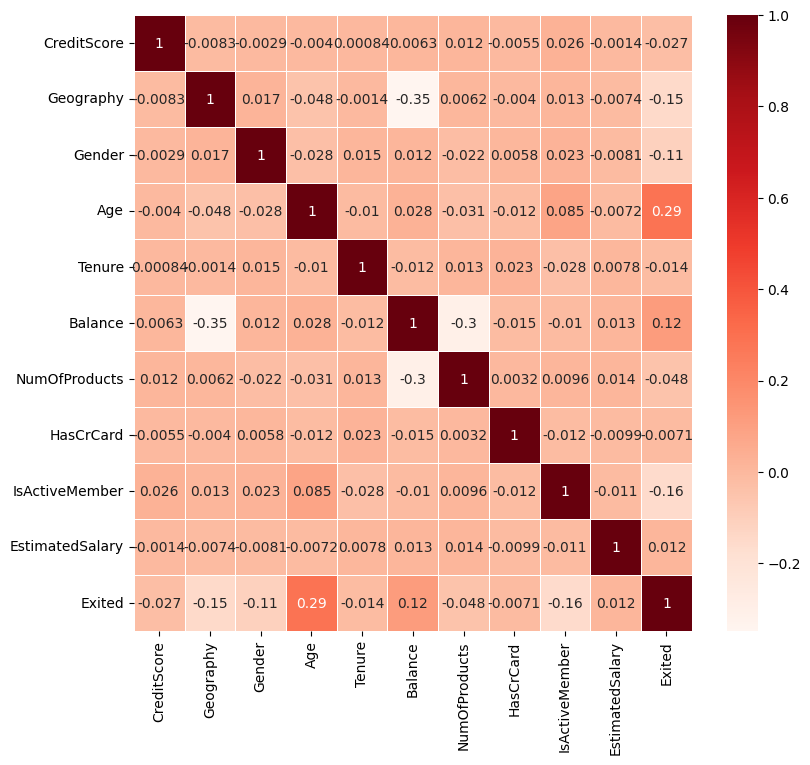

In [16]:
correlation_mat = df.corr() 
f, ax = plt.subplots(figsize=(9, 8)) 
sb.heatmap(correlation_mat,ax=ax, annot=True, cmap="Reds", linewidths=0.5)

A correlation matrix allows us to see which attributes have higher correlation value, meaning statistical they move in coordination to one another in a higher degree. The matrix shows us that the attribute which has greatest correlation value with 'Exited' is 'Age', folllowed by 'Balance'.

## 4. Classification Algorithms

With all the analysis done, we will now train and test different classification algorithms in our dataset to find out which is the best algorithm for predicting which customers are most likely to exit the bank (churn).

Before train and test the different algorithms, we need to split the dataset into features and target variable ("Exited") and split the data into training set (70%) and testing set (30%).

In [17]:
# Splitting the dataset into features (X) and target variable (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)

After that we are able to train and test the classification algorithms we want to use in our dataset.

### Decision Trees

We are now going to train and test the algorithm Decision Trees.

In [18]:
# Train Decision Trees
dt_model = DecisionTreeClassifier(random_state=42)
start_time_dt = time.time()
dt_model.fit(X_train_scaled, y_train)
end_time_dt = time.time()
time_taken_dt = end_time_dt - start_time_dt
print(f"Time taken to train Decision Trees: {time_taken_dt:.5f} seconds")

Time taken to train Decision Trees: 0.06000 seconds


In [19]:
# Test Decision Trees
y_pred_dt = dt_model.predict(X_test_scaled)

predic_act = pd.DataFrame({'Expected': y_pred_dt, 'Actual': y_test})
predic_act

,Expected,Actual
6252,0,0
4684,0,0
1731,1,0
4742,0,0
4521,0,0
...,...,...
8014,0,0
1074,0,0
3063,0,0
6487,0,0


In [20]:
print("Classification Report for Decision Trees:\n")
score_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy Obtained: {:.5f}".format(score_dt))
auc_dt = roc_auc_score(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt)
print("F1 Score:", f1_dt)
print(classification_report(y_test, y_pred_dt))

Classification Report for Decision Trees:

Accuracy Obtained: 0.77100
AUC: 0.6792898938582963
F1 Score: 0.7796791989521746
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2416
           1       0.43      0.53      0.47       584

    accuracy                           0.77      3000
   macro avg       0.65      0.68      0.66      3000
weighted avg       0.79      0.77      0.78      3000



Now we plot the confusion matrix for this classification algorithm.

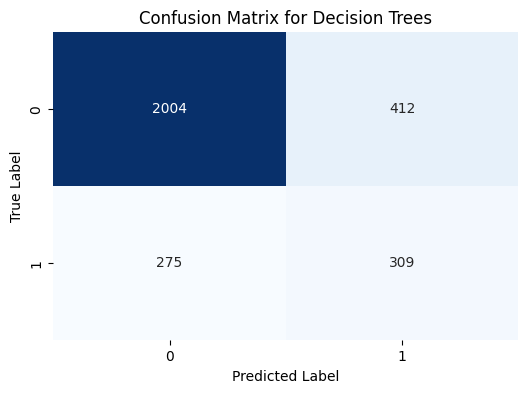

In [21]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for Decision Trees")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 2004 True Negatives, 275 False Negatives, 412 False Positives, and 309 True Positives. 

### Logistic Regression

We are now going to train and test the algorithm Logistic Regression.

In [22]:
# Train Logistic Regression
logistic_model = LogisticRegression(random_state=42)
start_time_lr = time.time()
logistic_model.fit(X_train_scaled, y_train)
end_time_lr = time.time()
time_taken_lr = end_time_lr - start_time_lr
print(f"Time taken to train Logistic Regression: {time_taken_lr:.5f} seconds")

Time taken to train Logistic Regression: 0.01100 seconds


In [23]:
# Test Logistic Regression
y_pred_logistic = logistic_model.predict(X_test_scaled)

predic_act = pd.DataFrame({'Expected': y_pred_logistic, 'Actual': y_test})
predic_act

,Expected,Actual
6252,0,0
4684,0,0
1731,1,0
4742,1,0
4521,0,0
...,...,...
8014,0,0
1074,0,0
3063,0,0
6487,0,0


In [24]:
print("Classification Report for Logistic Regression:\n")
score_lr = accuracy_score(y_test, y_pred_logistic)
print("Accuracy Obtained: {:.5f}".format(score_lr))
auc_lr = roc_auc_score(y_test, logistic_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc_lr)
f1_lr = f1_score(y_test, y_pred_logistic, average='weighted')
recall_lr = recall_score(y_test, y_pred_logistic)
print("F1 Score:", f1_lr)
print(classification_report(y_test, y_pred_logistic))

Classification Report for Logistic Regression:

Accuracy Obtained: 0.71033
AUC: 0.7719363773473646
F1 Score: 0.73732997641905
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      2416
           1       0.37      0.70      0.48       584

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.80      0.71      0.74      3000



Now we plot the confusion matrix for this classification algorithm.

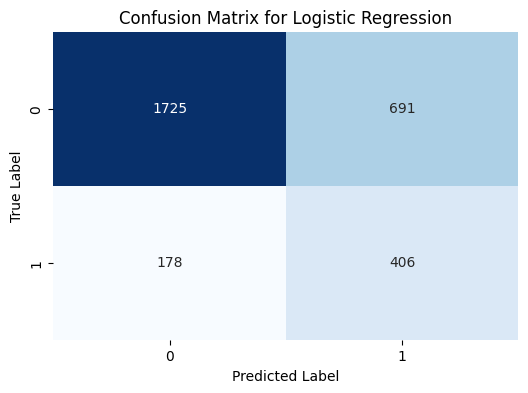

In [25]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 1725 True Negatives, 178 False Negatives, 691 False Positives, and 406 True Positives.

### Random Forest

We are now going to train and test the algorithm Random Forest.

In [26]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
start_time_rf = time.time()
rf_model.fit(X_train_scaled, y_train)
end_time_rf = time.time()
time_taken_rf = end_time_rf - start_time_rf
print(f"Time taken to train Random Forest: {time_taken_rf:.5f} seconds")

Time taken to train Random Forest: 1.39800 seconds


In [27]:
# Test Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)

predic_act = pd.DataFrame({'Expected': y_pred_rf, 'Actual': y_test})
predic_act

,Expected,Actual
6252,0,0
4684,0,0
1731,0,0
4742,0,0
4521,0,0
...,...,...
8014,0,0
1074,0,0
3063,0,0
6487,0,0


In [28]:
print("Classification Report for Random Forest:\n")
score_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Obtained: {:.5f}".format(score_rf))
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf)
print("F1 Score:", f1_rf)
print(classification_report(y_test, y_pred_rf))

Classification Report for Random Forest:

Accuracy Obtained: 0.84400
AUC: 0.8552164366551755
F1 Score: 0.8441010351966873
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2416
           1       0.60      0.60      0.60       584

    accuracy                           0.84      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.84      0.84      0.84      3000



Now we plot the confusion matrix for this classification algorithm.

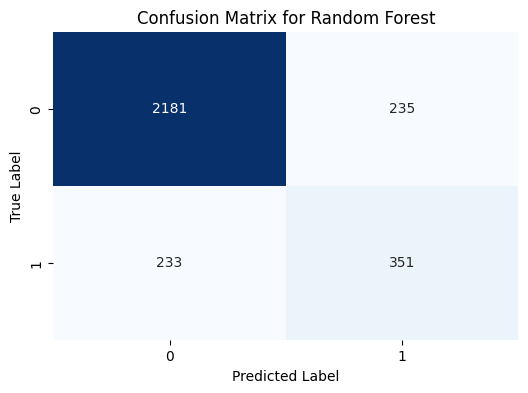

In [29]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 2181 True Negatives, 233 False Negatives, 235 False Positives, and 351 True Positives.

### K-Nearest Neighbors (K-NN)

We are now going to train and test the algorithm K-Nearest Neighbors (K-NN)​.

In [30]:
# Train K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
start_time_knn = time.time()
knn_model.fit(X_train_scaled, y_train)
end_time_knn = time.time()
time_taken_knn = end_time_knn - start_time_knn
print(f"Time taken to train K-Nearest Neighbors: {time_taken_knn:.5f} seconds")

Time taken to train K-Nearest Neighbors: 0.02600 seconds


In [31]:
# Test K-Nearest Neighbors
y_pred_knn = knn_model.predict(X_test_scaled)

predic_act = pd.DataFrame({'Expected': y_pred_knn, 'Actual': y_test})
predic_act

,Expected,Actual
6252,0,0
4684,0,0
1731,0,0
4742,0,0
4521,1,0
...,...,...
8014,0,0
1074,0,0
3063,0,0
6487,0,0


In [32]:
print("Classification Report for K-Nearest Neighbors:\n")
score_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy Obtained: {:.5f}".format(score_knn))
auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn)
print("F1 Score:", f1_knn)
print(classification_report(y_test, y_pred_knn))

Classification Report for K-Nearest Neighbors:

Accuracy Obtained: 0.73867
AUC: 0.7690060696951828
F1 Score: 0.7595255623436779
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      2416
           1       0.40      0.65      0.49       584

    accuracy                           0.74      3000
   macro avg       0.65      0.71      0.66      3000
weighted avg       0.80      0.74      0.76      3000



Now we plot the confusion matrix for this classification algorithm.

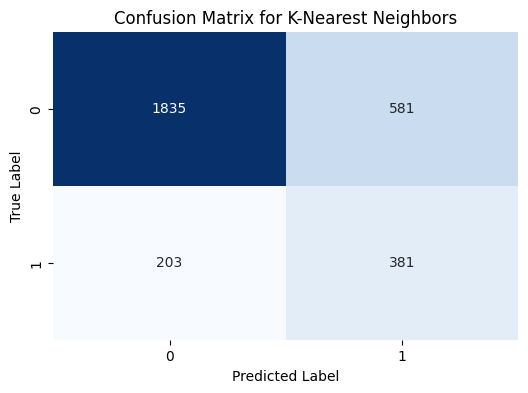

In [33]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for K-Nearest Neighbors")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 1835 True Negatives, 203 False Negatives, 581 False Positives, and 381 True Positives.

### Support Vector Machine (SVM)

We are now going to train and test the algorithm Support Vector Machine (SVM)​.

In [34]:
# Train Support Vector Machine
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
start_time_svm = time.time()
svm_model = SVC(probability=True)  # Enable probability estimates
svm_model.fit(X_train_scaled, y_train)
end_time_svm = time.time()
time_taken_svm = end_time_svm - start_time_svm
print(f"Time taken to train Support Vector Machine: {time_taken_svm:.5f} seconds")

Time taken to train Support Vector Machine: 15.04800 seconds


In [35]:
# Test Support Vector Machine
y_pred_svm = svm_model.predict(X_test_scaled)

predic_act = pd.DataFrame({'Expected': y_pred_svm, 'Actual': y_test})
predic_act

,Expected,Actual
6252,0,0
4684,0,0
1731,0,0
4742,0,0
4521,0,0
...,...,...
8014,0,0
1074,0,0
3063,0,0
6487,0,0


In [36]:
print("Classification Report for Support Vector Machine:\n")
score_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy Obtained: {:.5f}".format(score_svm))
auc_svm = roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm)
print("F1 Score:", f1_svm)
print(classification_report(y_test, y_pred_svm))

Classification Report for Support Vector Machine:

Accuracy Obtained: 0.78300
AUC: 0.8417711829810397
F1 Score: 0.7986697369418148
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      2416
           1       0.46      0.72      0.56       584

    accuracy                           0.78      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.83      0.78      0.80      3000



Now we plot the confusion matrix for this classification algorithm.

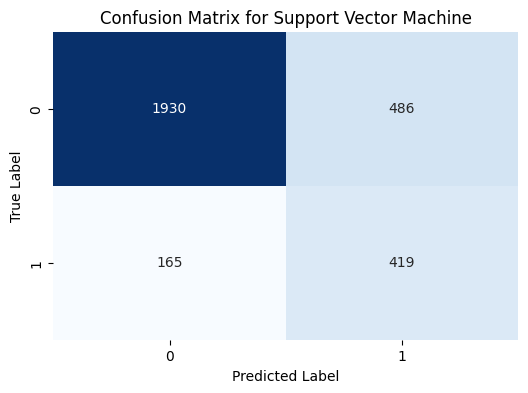

In [37]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for Support Vector Machine")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 1930 True Negatives, 165 False Negatives, 486 False Positives, and 419 True Positives.

### Naive Beys

We are now going to train and test the algorithm Naive Beys​.

In [38]:
# Train Naive Beys
nb_model = GaussianNB()
start_time_nb = time.time()
nb_model.fit(X_train_scaled, y_train)
end_time_nb = time.time()
time_taken_nb = end_time_nb - start_time_nb
print(f"Time taken to train Naive Beys: {time_taken_nb:.5f} seconds")

Time taken to train Naive Beys: 0.00400 seconds


In [39]:
# Test Naive Beys
y_pred_nb = nb_model.predict(X_test_scaled)

predic_act = pd.DataFrame({'Expected': y_pred_nb, 'Actual': y_test})
predic_act

,Expected,Actual
6252,0,0
4684,0,0
1731,1,0
4742,1,0
4521,0,0
...,...,...
8014,1,0
1074,0,0
3063,0,0
6487,0,0


In [40]:
print("Classification Report for Naive Beys:\n")
score_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy Obtained: {:.5f}".format(score_nb))
auc_nb = roc_auc_score(y_test, nb_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb)
print("F1 Score:", f1_nb)
print(classification_report(y_test, y_pred_nb))

Classification Report for Naive Beys:

Accuracy Obtained: 0.73733
AUC: 0.8097847965617345
F1 Score: 0.7607220426632192
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      2416
           1       0.40      0.72      0.52       584

    accuracy                           0.74      3000
   macro avg       0.66      0.73      0.67      3000
weighted avg       0.82      0.74      0.76      3000



Now we plot the confusion matrix for this classification algorithm.

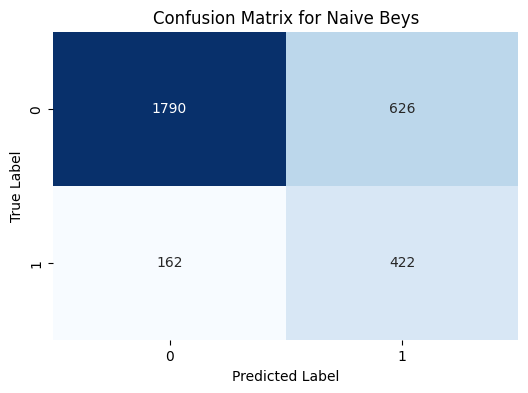

In [41]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for Naive Beys")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 1790 True Negatives, 162 False Negatives, 626 False Positives, and 422 True Positives.

### CatBoost Classifier

We are now going to train and test the algorithm CatBoost​.

In [42]:
# Train CatBoost
catboost_model = CatBoostClassifier(iterations=1000, 
                                    learning_rate=0.1, 
                                    depth=6,
                                    loss_function='Logloss',
                                    verbose=100)
start_time_catboost = time.time()
catboost_model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test))
end_time_catboost = time.time()
time_taken_catboost = end_time_catboost - start_time_catboost
print(f"Time taken to train CatBoost: {time_taken_catboost:.5f} seconds")

0:	learn: 0.6385900	test: 0.6415022	best: 0.6415022 (0)	total: 142ms	remaining: 2m 21s
100:	learn: 0.2527550	test: 0.3456808	best: 0.3456808 (100)	total: 877ms	remaining: 7.8s
200:	learn: 0.1997771	test: 0.3337026	best: 0.3334767 (175)	total: 1.64s	remaining: 6.51s
300:	learn: 0.1721677	test: 0.3335803	best: 0.3326123 (234)	total: 2.37s	remaining: 5.51s
400:	learn: 0.1510424	test: 0.3344391	best: 0.3326123 (234)	total: 3.11s	remaining: 4.64s
500:	learn: 0.1347484	test: 0.3376124	best: 0.3326123 (234)	total: 3.83s	remaining: 3.82s
600:	learn: 0.1200263	test: 0.3388897	best: 0.3326123 (234)	total: 4.55s	remaining: 3.02s
700:	learn: 0.1083963	test: 0.3422888	best: 0.3326123 (234)	total: 5.28s	remaining: 2.25s
800:	learn: 0.0972742	test: 0.3461780	best: 0.3326123 (234)	total: 5.99s	remaining: 1.49s
900:	learn: 0.0874758	test: 0.3492353	best: 0.3326123 (234)	total: 6.72s	remaining: 739ms
999:	learn: 0.0793863	test: 0.3518231	best: 0.3326123 (234)	total: 7.44s	remaining: 0us

bestTest = 0.33

In [43]:
# Test CatBoost
y_pred_catboost = catboost_model.predict(X_test_scaled)

predic_act = pd.DataFrame({'Expected': y_pred_nb, 'Actual': y_test})
predic_act

,Expected,Actual
6252,0,0
4684,0,0
1731,1,0
4742,1,0
4521,0,0
...,...,...
8014,1,0
1074,0,0
3063,0,0
6487,0,0


In [44]:
print("Classification Report for CatBoost:\n")
score_catboost = accuracy_score(y_test, y_pred_catboost)
print("Accuracy Obtained: {:.5f}".format(score_catboost))
auc_catboost = roc_auc_score(y_test, catboost_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost, average='weighted')
recall_catboost = recall_score(y_test, y_pred_catboost)
print("F1 Score:", f1_catboost)
print(classification_report(y_test, y_pred_catboost))

Classification Report for CatBoost:

Accuracy Obtained: 0.86433
AUC: 0.8645821520910821
F1 Score: 0.8583856109993997
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2416
           1       0.69      0.55      0.61       584

    accuracy                           0.86      3000
   macro avg       0.79      0.75      0.77      3000
weighted avg       0.86      0.86      0.86      3000



Now we plot the confusion matrix for this classification algorithm.

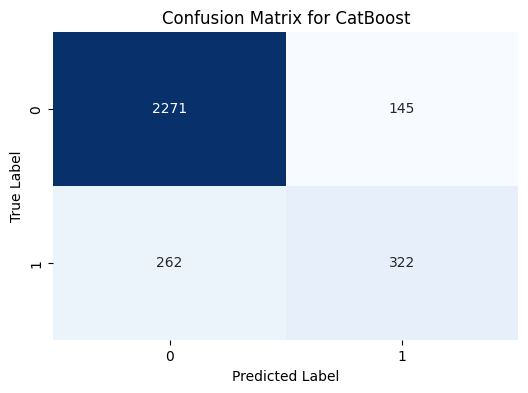

In [45]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for CatBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 2271 True Negatives, 262 False Negatives, 145 False Positives, and 322 True Positives.

### Neural Networks

We are now going to train and test the algorithm Neural Networks​.

In [46]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define the model
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train Neural Networks
start_time_nn = time.time()
nn_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, class_weight=class_weights_dict)
end_time_nn = time.time()
time_taken_nn = end_time_nn - start_time_nn
print(f"Time taken to train Neural Networks: {time_taken_nn:.5f} seconds")

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6010 - loss: 0.6684 - val_accuracy: 0.5160 - val_loss: 0.7616
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7123 - loss: 0.5678 - val_accuracy: 0.6003 - val_loss: 0.7185
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7463 - loss: 0.5337 - val_accuracy: 0.6638 - val_loss: 0.6559
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7499 - loss: 0.5146 - val_accuracy: 0.6052 - val_loss: 0.7082
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7577 - loss: 0.5025 - val_accuracy: 0.6102 - val_loss: 0.6721
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7645 - loss: 0.4867 - val_accuracy: 0.6453 - val_loss: 0.6297
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7749 - loss: 0.4774 - val_accuracy: 0.6201 - val_loss: 0.6569
Epoch 8/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7811 - loss: 0.4605 - val_accuracy: 0.

In [62]:
# Test Neural Networks
y_pred_prob = nn_model.predict(X_train_scaled)
y_pred_nn = (y_pred_prob > 0.5).astype("int32")

print("Classification Report for Neural Networks:\n")
score_nn = accuracy_score(y_train, y_pred_nn)
print("Accuracy Obtained: {:.5f}".format(score_nn))
auc_nn = roc_auc_score(y_test, nn_model.predict(X_test_scaled))
print("AUC:", auc_nn)
recall_nn = recall_score(y_train, y_pred_nn)
f1_nn = f1_score(y_train, y_pred_nn)
print("F1 Score:", f1_nn)
print(classification_report(y_train, y_pred_nn))

347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
Classification Report for Neural Networks:

Accuracy Obtained: 0.78619
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
AUC: 0.858473475913998
F1 Score: 0.756568144499179
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      5547
           1       0.88      0.66      0.76      5547

    accuracy                           0.79     11094
   macro avg       0.80      0.79      0.78     11094
weighted avg       0.80      0.79      0.78     11094



Now we plot the confusion matrix for this classification algorithm.

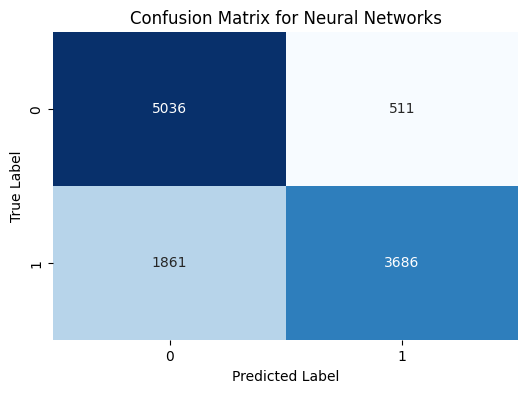

In [48]:
# Plot confusion matrix
cm = confusion_matrix(y_train, y_pred_nn)
plt.figure(figsize=(6, 4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix for Neural Networks")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

By observing the values of the confusion matrix, we can conclude that it has 5036 True Negatives, 1861 False Negatives, 511 False Positives, and 3686 True Positives.

### Model Comparison based on Their Performances

The `Accuracy`, `Area Under the Curve (AUC)`, `Precision`, `Recall`, `F1-score`, and `Support` are metrics used to evaluate the performance of a classification model.

- `Accuracy` is a metric that measures the proportion of instances that were correctly classified by the model.
- `Area Under the Curve (AUC)` is a metric that quantifies the overall performance of a binary classification model. The higher the AUC score, the better the model's performance in distinguishing between the positive and negative classes.
- `Precision` is the ratio of true positives to the total number of predicted positives. It measures how many of the predicted positive instances are actually positive.
- `Recall` is the ratio of true positives to the total number of actual positives. It measures how many of the actual positive instances are correctly identified by the classifier.
- `F1-score` is the harmonic mean of precision and recall. It takes both precision and recall into account and provides a single score that represents their balance.
- `Support` is the number of instances in each class.

The formulas for the metrics mentioned are:

- `Accuracy` = (TP + TN) / (TP + TN + FP + FN)
- `Precision` = TP / (TP + FP)
- `Recall` = TP / (TP + FN)
- `F1-score` = 2 * (precision * recall) / (precision + recall)
- `Support` is simply the number of instances in each class.

Where:

- `TP`: True Positives
- `FP`: False Positives
- `FN`: False Negatives

With the explanation above in mind, we conclude that a good classification model has an high `Accuracy`, an high `F1-score`, an high `Area Under the Curve (AUC)`, and, ideally, a low `Training Time`.

For our dataset, we use 7 different Classification Algorithms: `Decision Trees`​, `Logistic Regression`​, `Random Forest`​, `K-NN (K-Nearest Neighbors)`​, `SVM (Support Vector Machine)`​, `Naive Bayes`​, `CatBoost` and `Neural Networks`​. 
<br>
<br>
To evaluate the models we are going to display different plots for the metrics used for the evaluation performance.

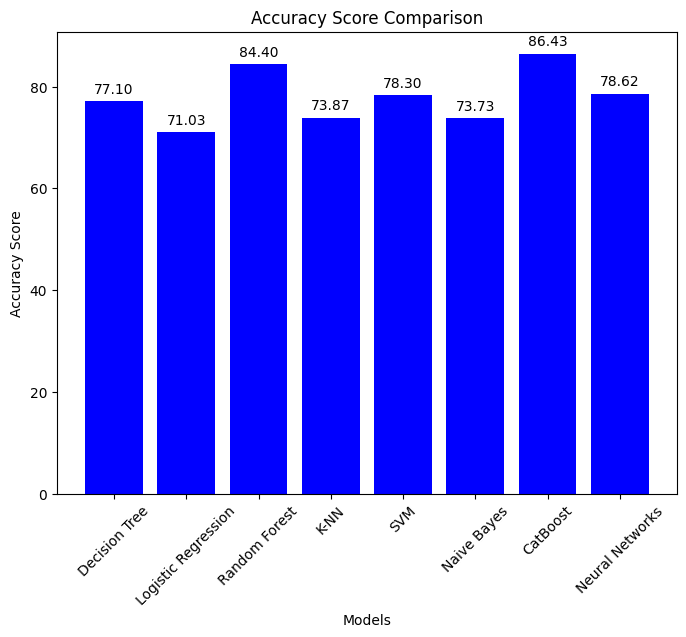

In [49]:
models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'K-NN', 'SVM', 'Naive Bayes', 'CatBoost', 'Neural Networks']
accuracy_scores = [score_dt*100, score_lr*100, score_rf*100, score_knn*100, score_svm*100, score_nb*100, score_catboost*100, score_nn*100]
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_scores, color='blue')
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 1, "{:.2f}".format(v), ha='center', va='bottom', color='black')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score Comparison')
plt.xticks(rotation=45)
plt.show()

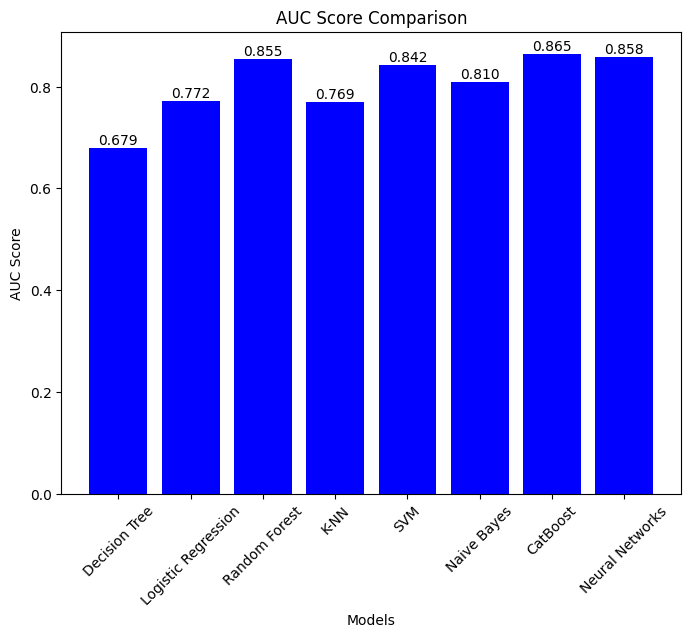

In [50]:
models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'K-NN', 'SVM', 'Naive Bayes', 'CatBoost', 'Neural Networks']
auc_scores = [auc_dt, auc_lr, auc_rf, auc_knn, auc_svm, auc_nb, auc_catboost, auc_nn]
plt.figure(figsize=(8, 6))
plt.bar(models, auc_scores, color='blue')
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.001, "{:.3f}".format(v), ha='center', va='bottom', color='black')
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('AUC Score Comparison')
plt.xticks(rotation=45)
plt.show()

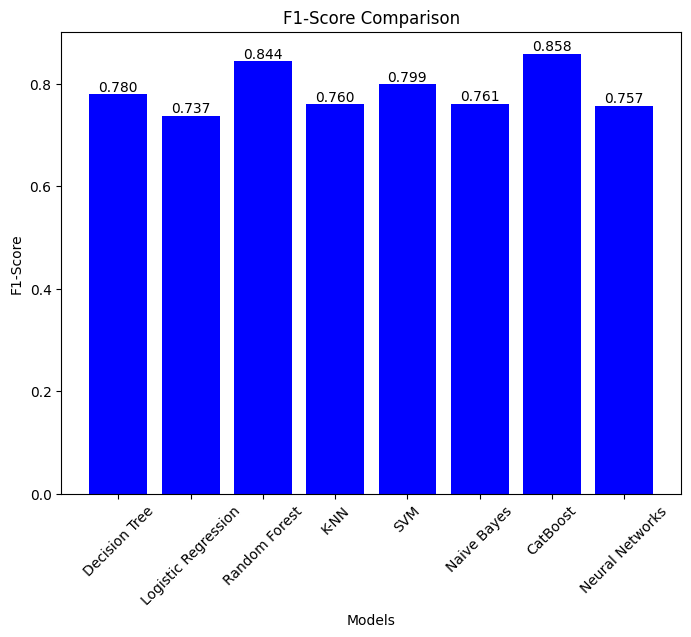

In [51]:
models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'K-NN', 'SVM', 'Naive Bayes', 'CatBoost', 'Neural Networks']
f1_scores = [f1_dt, f1_lr, f1_rf, f1_knn, f1_svm, f1_nb, f1_catboost, f1_nn]
plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color='blue')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.0001, "{:.3f}".format(v), ha='center', va='bottom', color='black')
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison')
plt.xticks(rotation=45)
plt.show()

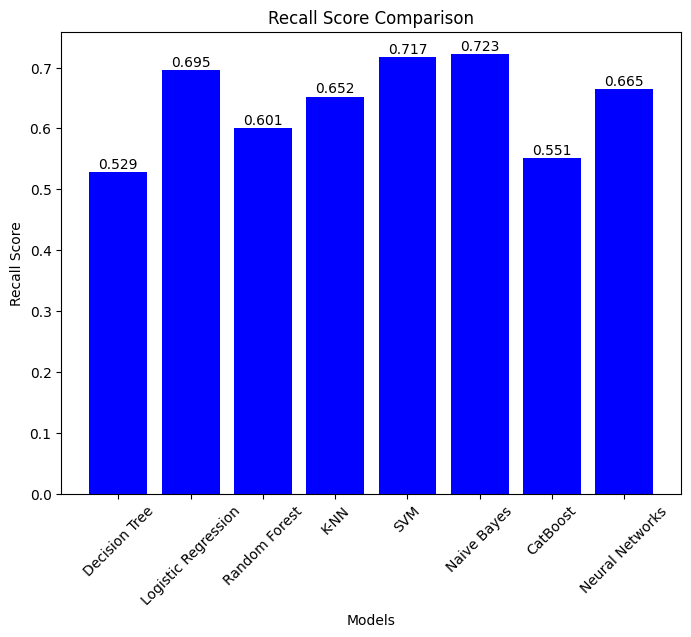

In [52]:
models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'K-NN', 'SVM', 'Naive Bayes', 'CatBoost', 'Neural Networks']
recall_scores = [recall_dt, recall_lr, recall_rf, recall_knn, recall_svm, recall_nb, recall_catboost, recall_nn]
plt.figure(figsize=(8, 6))
plt.bar(models, recall_scores, color='blue')
for i, v in enumerate(recall_scores):
    plt.text(i, v + 0.001, "{:.3f}".format(v), ha='center', va='bottom', color='black')
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.title('Recall Score Comparison')
plt.xticks(rotation=45)
plt.show()

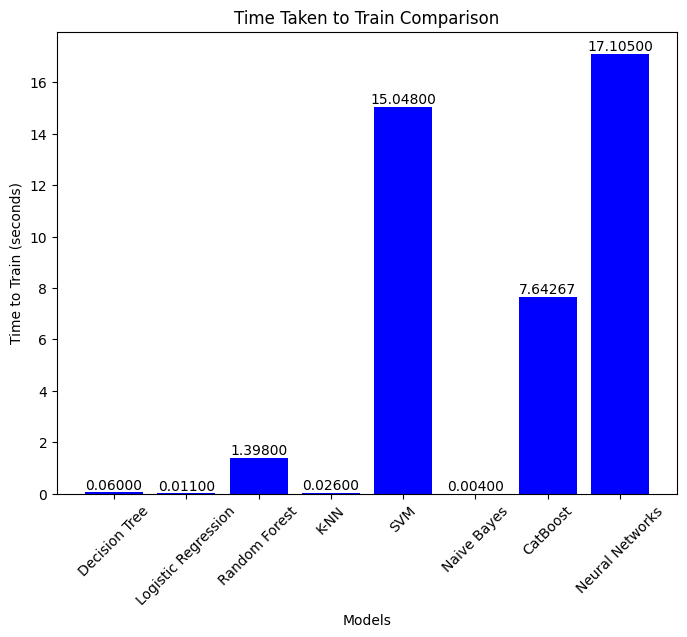

In [53]:
models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'K-NN', 'SVM', 'Naive Bayes', 'CatBoost', 'Neural Networks']
time_train = [time_taken_dt, time_taken_lr, time_taken_rf, time_taken_knn, time_taken_svm, time_taken_nb, time_taken_catboost, time_taken_nn]
plt.figure(figsize=(8, 6))
plt.bar(models, time_train, color='blue')
for i, v in enumerate(time_train):
    plt.text(i, v + 0.01,  "{:.5f}".format(v), ha='center', va='bottom', color='black')
plt.xlabel('Models')
plt.ylabel('Time to Train (seconds)')
plt.title('Time Taken to Train Comparison')
plt.xticks(rotation=45)
plt.show()

After observing the graphics about the accuracy, AUC, f1-score, recall, and time to train of each algorithm, we can conclude that:
- **Accuracy** - The best algorithm based on the Accuracy is the `CatBoost`.
- **AUC** - The best algorithm based on the AUC is the `CatBoost`.
- **F1-Score** - The best algorithm based on the F1-Score is the `CatBoost`.
- **Recall** - The best algorithm based on the Recall is the `Naive Bayes`.
- **Time Taken to Train** - The best algorithm based on the time to train is the `Naive Bayes`.

Our dataset is an unbalanced (the target variable "Exited" has many more 0 (8000) than 1 (2000) values) dataset so the best metrics to evaluate the algorithms are the AUC, the F1-Score and the Recall. <br>
With that in mind and looking at the results for each of those metrics, we can conclude that the best algorithm for our dataset is the `CatBoost` because, despite not showing the best Recall, it shows the best values in the AUC and the F1-Score metric.

## Group Members

André dos Santos Faria Relva - up202108695 \
Pedro Guilherme Pinto Magalhães - up202108756 \
Rafael Azevedo Alves - up202004476